In [147]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, losses
from tensorflow.keras.datasets import mnist
from scipy.stats import norm
import collections
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [148]:
def load_dataset():
    
    # hd data is alpha=0.75, beta=0.25
    hd_full_data = pd.read_csv("C:/Users/Matthew/Documents/University/Year 5/MPhys Project/Simulations/Original/5e4_snaps_alpha75_beta25.csv", header=None)
    #hd_full_data['y'] = [[(0.75, 0.25), 0.75]] * hd_full_data.shape[0]
    hd_full_data['y'] = [1] * hd_full_data.shape[0]
    # ld data is alpha=0.25, beta=0.75
    ld_full_data = pd.read_csv("C:/Users/Matthew/Documents/University/Year 5/MPhys Project/Simulations/Original/5e4_snaps_alpha25_beta75.csv", header=None)
    #ld_full_data['y'] = [[(0.25, 0.75), 0.25]] * ld_full_data.shape[0]
    ld_full_data['y'] = [2] * ld_full_data.shape[0]
    # mc data is alpha=0.60, beta=0.60
    mc_full_data = pd.read_csv("C:/Users/Matthew/Documents/University/Year 5/MPhys Project/Simulations/Original/5e4_snaps_alpha60_beta60.csv", header=None)
    #mc_full_data['y'] = [[(0.60, 0.60), 0.5]] * mc_full_data.shape[0]
    mc_full_data['y'] = [3] * mc_full_data.shape[0]
    
    combined_full_data = pd.concat([hd_full_data, ld_full_data, mc_full_data])
    #combined_full_data = combined_full_data.sample(frac=1).reset_index(drop=True)
    
    X = combined_full_data.iloc[:, :-1]
    y = combined_full_data.iloc[:, -1]
    
    return X, y
    

In [149]:
class VAE:
    
    def __init__(self, batch_size=100, original_dim = 100, intermediate_dim = 50, latent_dim = 3, epochs=50, epsilon=0.5):
        #
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.epochs = epochs
        self.epsilon_std = epsilon
        
    def sampling(self, args):
        # Sampling from the latent variables using the means and log-variances
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0.,
                                  stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
        #return z_mean + K.exp(z_log_var) * epsilon
    
    def build(self):
        #
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim = self.intermediate_dim
        
        # encoder
        self.x = Input(shape=(original_dim,))
        h = Dense(intermediate_dim, activation='relu')(self.x)
        self.z_mean = Dense(latent_dim)(h)
        self.z_log_var = Dense(latent_dim)(h)
        
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])
        
        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(intermediate_dim, activation='relu')
        decoder_mean = Dense(original_dim, activation='sigmoid')
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)
        
        #decoder
        decoder_input = Input(shape=(latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _x_decoded_mean = decoder_mean(_h_decoded)
        
        self.generator = Model(decoder_input, _x_decoded_mean)

        
        # end-to-end VAE model
        self.vae = Model(self.x, x_decoded_mean)
        
        # encoder, from inputs to latent space
        self.encoder = Model(self.x, self.z_mean)
        
        # decoder
        #self.decoder = Model(decoder_input, _x_decoded_mean)
        
        # Compute VAE loss
        self.vae.compile(optimizer='rmsprop', loss=self.vae_loss)
        
        # Prints a summary of the architecture used
        self.vae.summary()

    def vae_loss(self, x, x_decoded_mean):
        #
        xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    def train(self, x_train, x_test):
        #
        #x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # flatten each sample out 
        #x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        #x_train = minmax_scale(x_train) # this step is required in order to use cross-entropy loss for reconstruction
        #x_test = minmax_scale(x_train) # scaling features in 0,1 interval
        
        
        self.vae.fit(x_train, x_train,
                shuffle=True,
                epochs=self.epochs,
                batch_size=self.batch_size,
                validation_data=(x_test, x_test)
                )

        # build a model to project inputs on the latent space
        #encoder = Model(self.x, self.z_mean)

    def predict_latent(self, xnew):
        # build a model to project inputs on the latent space
        return self.encoder.predict(xnew)
    
    def generate_decoding(self, znew):
        # Generate new fantasy particles 
        return self.generator.predict(znew)

In [150]:
X, y = load_dataset()

In [151]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.8)
print(xtrain.shape)

(30000, 100)


In [152]:
model = VAE(epochs=20, latent_dim=2, epsilon=0.2) # Choose model parameters
model.build() # Construct VAE model using Keras
model.train(xtrain, xtest) # Trains VAE model based on custom loss function

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 50)           5050        input_23[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 2)            102         dense_55[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 2)            102         dense_55[0][0]                   
___________________________________________________________________________________________

In [153]:
zpred = model.predict_latent(xtest)
print(zpred.shape)

(120000, 2)


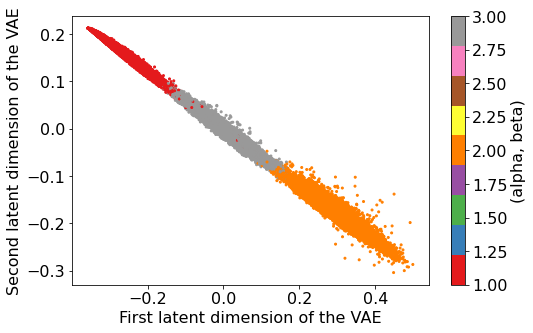

In [154]:
# To make plots pretty
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytest, s=4, cmap="Set1")
ax.set_xlabel('First latent dimension of the VAE')
ax.set_ylabel('Second latent dimension of the VAE')
plt.colorbar(sc, label='(alpha, beta)')
#plt.savefig('latent_plot.png')
plt.show()